# This notebook discusses the simplified Draper adder and subtractor, which adds (subtract) classical number b to (from) a quantum number a

Here is the picture of the circuit from arXiv:quant-ph/0205095
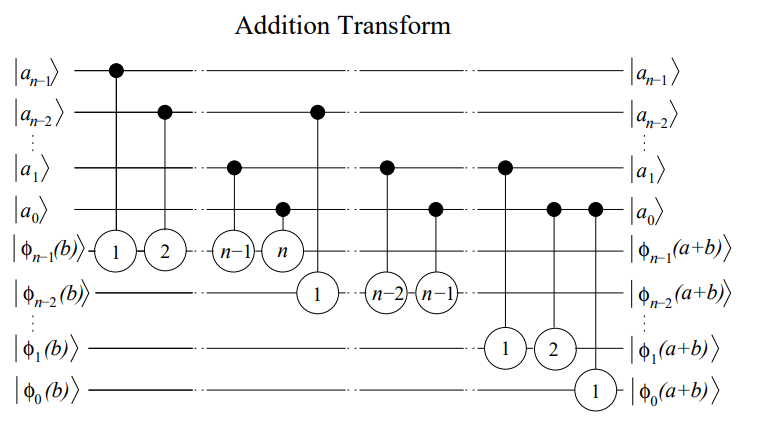

where

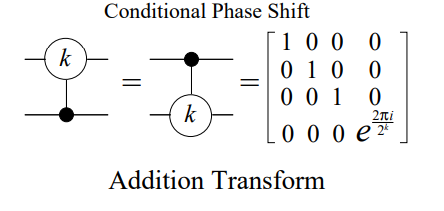

In the notebook there are 2 bits adder, and n-bits adder realized. Each code has measurement 
## Important notes
We work withn-bits numbers. 
If a + b >2^n, then the addition goes for all n bits, the highest bit (n + 1) is just lost after the addition.
If a - b < 0, the the algorithm actually perfroms a + 2^(n+1) - b. So, one can think that bit n+1 is added to number a, 1 assigned to that bit, then subtraction happens.


# Content
1. 2-bits adder circuit
2. n-bits adder circuit
3. n-bits adder circuit as a function from quatum_routines library
4. n-bits subtractor circuit as a function from quatum_routines library



## Comments on the code
1) The quantum register qreg represents a binary number (defined by q_num) added to a classical binary number creg defined by cl_num
2) The qubit 0 of qreg is the highest bit of the q_num number
3) The leftmost (first element of the array) digit in the q_num array is the highest number in the quantum number. It corresponds to zero qubit in the quantum register qreg
4) Similar notations is used for the classical number
5) To create a classical number we start with quantum register and perform measurements to get classical number. Therefore, total number of qubits is twice higher than the number of bits in the added umbers
6) 

In [33]:
import qiskit
import numpy as np
import quantum_routines as qr
from quantum_routines import QFTn
from quantum_routines import IQFTn


# 2-bits adder

Variables q_num and cl_num defines the added numbers. Note that the examples considered here are valid for pure quantum state. So, no superpositions is used. To use a superposition, one needs to prepare the register qreg in a superposition state instaed of pure state.

Result os addition is shoun in the hystoram below. Historgam state shows 4 digits. First 2 upper digits are quantum number added. Lowest 2 digits is the resulting number. The higher the bit in space the higher the bit in a number.


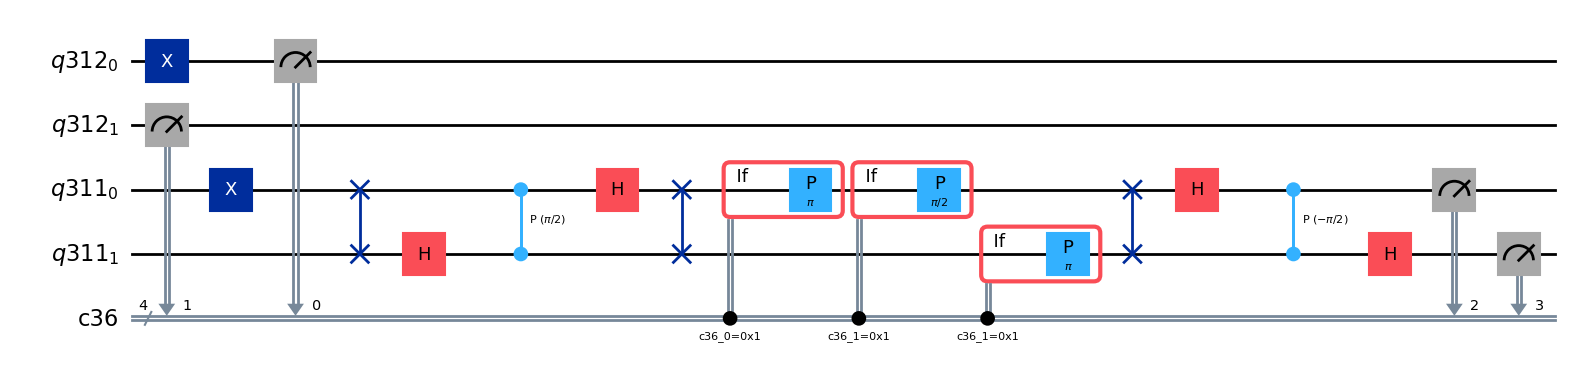

In [34]:
''' 2 bit adder '''
q_num = [1, 0] # quantum number, 
cl_num = [1, 0 ] #classical number

PI = np.pi
bit_size = 2 #size (number of digits) of the binary number
qreg    = qiskit.QuantumRegister(2) #this quantum register stores the added quantum number a
qreg_cl = qiskit.QuantumRegister(2) #ancilla qubits to replacing classical imputs
creg    = qiskit.ClassicalRegister(4) #this classical register stores classical number b

adder = qiskit.QuantumCircuit(qreg_cl,qreg,creg)


#converting binary classical number cl_num into a classical register output, each number in the list is a single digit of the binary classical number
#b[0] is the highest digit, b[BitSize-1] is the smallest digit
for i in range(bit_size):
    if cl_num[i] == 1:
        adder.x(qreg_cl[i])

for i in range(bit_size):
    adder.measure(qreg_cl[i], creg[i])

for i in range(bit_size):
    if q_num[i] == 1:
        adder.x(qreg[i])

adder.swap(qreg[0],qreg[1])

adder=QFTn(qreg, adder)

for i_q in range(bit_size): #loop ober the quantum register
    for i_r in range(bit_size - i_q):
        with adder.if_test((creg[i_r + i_q], 1)):
            adder.p(2 * PI / (pow(2, i_r + 1)), qreg[i_q])

adder = IQFTn(qreg, adder)

for i in range(bit_size):
    adder.measure(qreg[i], creg[i+bit_size])

adder.draw('mpl')

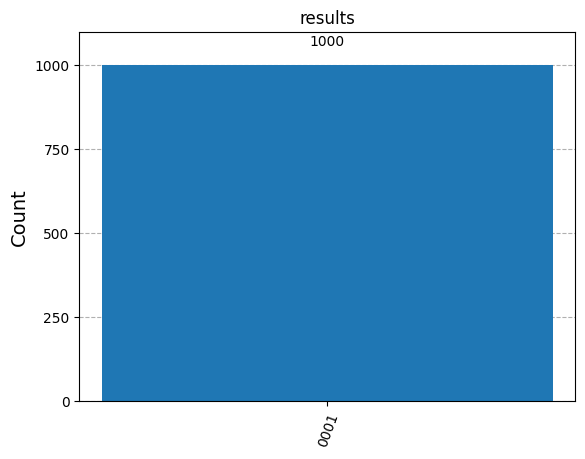

In [35]:
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city
import numpy

simulator = Aer.get_backend('qasm_simulator') 
#result = execute(circuit, simulator, shots=1000).result()
simulator = AerSimulator()
ShotNum=1000
circ = transpile(adder, simulator)
result = simulator.run(adder,shots=ShotNum).result()
counts = result.get_counts(adder)
plot_histogram(counts, title='results')

# n-bits adder
Variables q_num and cl_num defines the added numbers. Note that the examples considered here are valid for pure quantum state. So, no superpositions is used. To use a superposition, one needs to prepare the register qreg in a superposition state instaed of pure state.

Result os addition is shoun in the hystoram below. Historgam state shows 4 digits. First bit_size/2 upper digits are quantum number added. Lowest bit_size/2 digits is the resulting number. The higher the bit in space the higher the bit in a number.

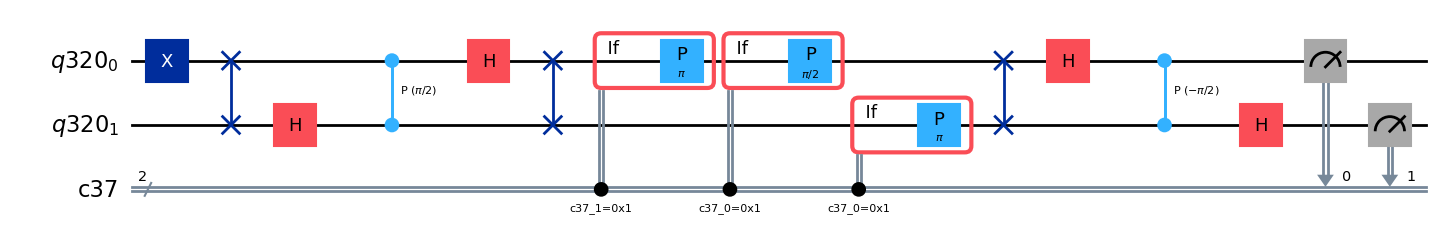

In [36]:
''' n-bits adder '''
PI = np.pi
bit_size = 2 #size (number of digits) of the binary number

#default numbers
q_num = [0] * bit_size
cl_num = [0] * bit_size

q_num = [1, 0] # quantum number
cl_num = [1, 0] #classical number

qreg    = qiskit.QuantumRegister(bit_size) #this quantum register stores the added quantum number a
#qreg_cl = qiskit.QuantumRegister(bit_size) #ancilla qubits to replacing classical imputs
creg    = qiskit.ClassicalRegister(bit_size) #this classical register stores classical number b

adder = qiskit.QuantumCircuit(qreg,creg)

#converting binary classical number cl_num into a classical register output, each number in the list is a single digit of the binary classical number
#b[0] is the highest digit, b[BitSize-1] is the smallest digit

adder = qr.qubit_binary_prepare(qreg, cl_num, adder)

for i in range(0,int(np.floor(bit_size / 2))):
    adder.swap(qreg[i], qreg[bit_size - 1 - i])
    

adder = QFTn(qreg, adder)

for i_q in range(bit_size): #loop ober the quantum register
    for i_r in range(bit_size - i_q):
        with adder.if_test((cl_num[i_r + i_q], 1)):
            adder.p(2 * PI / (pow(2, i_r + 1)), qreg[i_q])

adder = IQFTn(qreg, adder)

adder = qr.qubits_meas(qreg, creg, adder)

adder.draw('mpl')

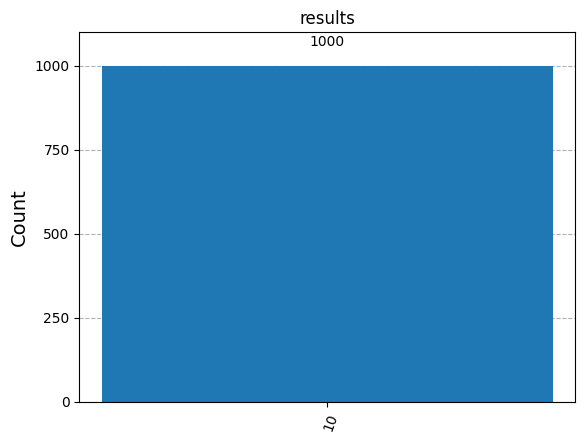

In [37]:
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city
import numpy

simulator = Aer.get_backend('qasm_simulator') 
#result = execute(circuit, simulator, shots=1000).result()
simulator = AerSimulator()
ShotNum=1000
circ = transpile(adder, simulator)
result = simulator.run(adder,shots=ShotNum).result()
counts = result.get_counts(adder)
plot_histogram(counts, title='results')

## n-bit Drapper adder controlled with quntum bits

In [16]:
bit_size = 2 #size (number of digits) of the binary number
control_bit_size = 2

from qiskit.circuit.library import SwapGate
from qiskit.circuit.library import PhaseGate

#default numbers
q_num = [0] * bit_size
cl_num = [0] * bit_size
contr_num = [0] * control_bit_size

q_num = [1, 1] # quantum number
cl_num = [1, 1] #classical number
contr_num = [1, 1] #control number

qreg    = qiskit.QuantumRegister(2 * bit_size + control_bit_size) #this quantum register stores the added quantum number a
creg    = qiskit.ClassicalRegister(bit_size) #this classical register stores classical number b
creg_res    = qiskit.ClassicalRegister(bit_size) #this classical register stores results of the calculations
adder = qiskit.QuantumCircuit(qreg,creg,creg_res)

#converting binary classical number cl_num into a classical register output, each number in the list is a single digit of the binary classical number
#b[0] is the highest digit, b[BitSize-1] is the smallest digit
adder = qr.qubit_binary_prepare(range(control_bit_size, bit_size + control_bit_size), q_num, adder)

#creating a classical number
adder = qr.qubit_binary_prepare(qreg[list(range(control_bit_size + bit_size, 2 * bit_size + control_bit_size))], cl_num, adder)
adder = qr.qubits_meas(qreg[list(range(control_bit_size + bit_size, 2 * bit_size + control_bit_size))], creg, adder)

#initializing the control bits
adder = qr.qubit_binary_prepare(range(control_bit_size), contr_num, adder)

for i in range(0,int(np.floor(bit_size / 2))):
    aux_gate = SwapGate().control(control_bit_size)
    qbit_list = list(range(0, control_bit_size))
    qbit_list.append(i + control_bit_size)
    qbit_list.append(bit_size + control_bit_size - 1 - i)
    adder.append(aux_gate,qbit_list)
    
aux_gate = qr.QFTn_contr_gate(bit_size, control_bit_size)
adder.append(aux_gate,list(range(0, bit_size + control_bit_size)))

for i_q in range(bit_size): #loop ober the quantum register
    for i_r in range(bit_size - i_q):
        with adder.if_test((creg[i_r + i_q], 1)):
            aux_gate = PhaseGate(2 * PI / (pow(2, i_r + 1))).control(control_bit_size)
            qbit_list = list(range(0,control_bit_size))
            qbit_list.append(i_q + control_bit_size)
            adder.append(aux_gate, qbit_list)
            #adder.p(2 * PI / (pow(2, i_r + 1)), qreg[i_q + control_bit_size])

aux_gate = qr.IQFTn_contr_gate(bit_size, control_bit_size)
adder.append(aux_gate,list(range(0, bit_size + control_bit_size)))

for i in range(0,int(np.floor(bit_size / 2))):
    aux_gate = SwapGate().control(control_bit_size)
    qbit_list = list(range(0, control_bit_size))
    qbit_list.append(i + control_bit_size)
    qbit_list.append(bit_size + control_bit_size - 1 - i)
    adder.append(aux_gate,qbit_list)
    


adder = qr.qubits_meas(qreg[list(range(control_bit_size , bit_size + control_bit_size))], creg_res, adder)

adder.draw('mpl')

NameError: name 'PI' is not defined

We perfromed addition of quantum number [1, 1] and classical number [1, 1].
The result is the lower half of bits in hystogram x-axis notation


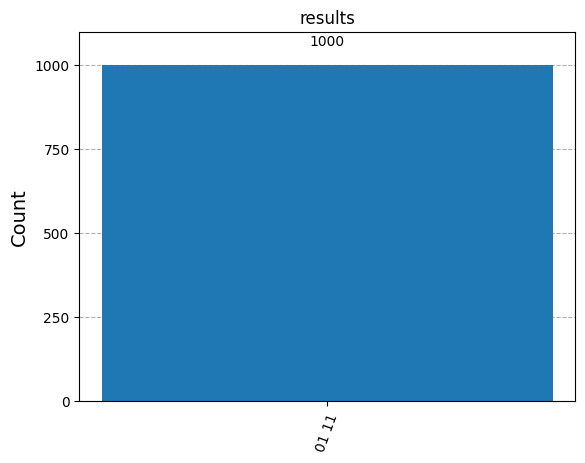

In [39]:
print('We perfromed addition of quantum number '+str(q_num) + ' and classical number ' + str(cl_num) + '.' )
print('The result is the lower half of bits in hystogram x-axis notation')
qr.plot_hyst_func(adder,1000)

# n-bit adder realized with functions from my library qauntum_routines
Variables q_num and cl_num defines the added numbers. Note that the examples considered here are valid for pure quantum state. So, no superpositions is used. To use a superposition, one needs to prepare the register qreg in a superposition state instaed of pure state.

There are control_bit_size qubits performing control of the Draper adder. They both should have |1> state to turn on the adder.
Control qubits are the upper control_bit_size quibits, added quantum number is the qubits below the control qubits

Result os addition is shoun in the hystoram below. Historgam state shows 4 digits. First bit_size/2 upper digits are quantum number added. Lowest bit_size/2 digits is the resulting number. The higher the bit in space the higher the bit in a number.

C:\Users\Oleg\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


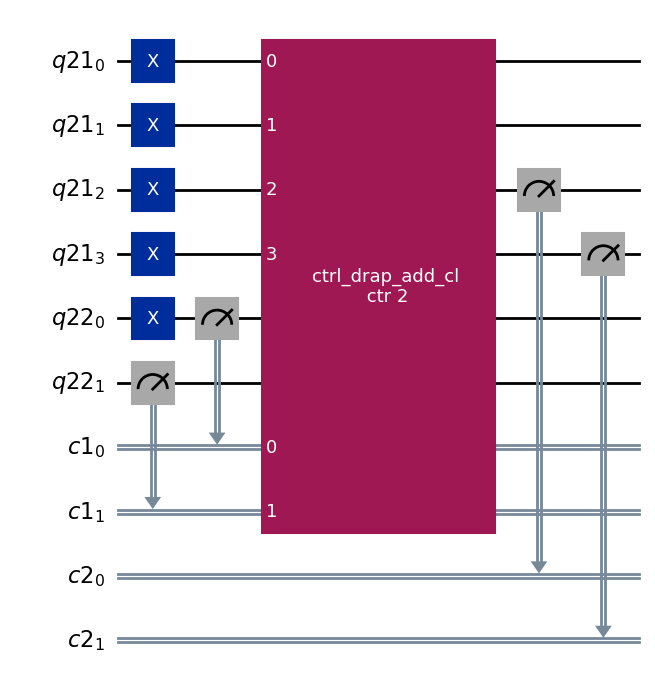

In [3]:
import qiskit
import numpy as np
import quantum_routines as qr
from quantum_routines import QFTn
from quantum_routines import IQFTn

bit_size = 2 #size (number of digits) of the binary number
control_bit_size = 2

#default numbers
q_num = [0] * bit_size
cl_num = [0] * bit_size
contr_num = [0] * control_bit_size

q_num = [1, 1] # quantum number (we assume here pure state, no superposition)
cl_num = [1, 0] #classical number
contr_num = [1, 1] #control number

q_reg    = qiskit.QuantumRegister(bit_size + control_bit_size) #this quantum register stores the added quantum number a
cl_reg    = qiskit.ClassicalRegister(bit_size) #this classical register stores classical number b
q_reg_cl    = qiskit.QuantumRegister(bit_size) # this is ancilla qubits to get classical number in the circuit
cl_reg_meas    = qiskit.ClassicalRegister(bit_size) # this classical register stores the result of summation

adder = qiskit.QuantumCircuit(q_reg, cl_reg, q_reg_cl, cl_reg_meas)

qbit_list = list(range(control_bit_size, control_bit_size + bit_size))
adder = qr.qubit_binary_prepare(q_reg[qbit_list], q_num, adder) #prepare quantum number

#prepare classical number
adder = qr.qubit_binary_prepare(q_reg_cl, cl_num, adder) 
adder = qr.qubits_meas(q_reg_cl, cl_reg, adder)

#prepare control qubits
qbit_list = list(range(control_bit_size))
adder = qr.qubit_binary_prepare(q_reg[qbit_list], contr_num, adder)

adder_instr = qr.draper_adder_cl_instr(bit_size, control_bit_size)
adder.append(adder_instr, q_reg, cl_reg)

#adder_instr = qr.draper_subtraction_cl_instr(bit_size, control_bit_size)
#adder.append(adder_instr, q_reg, cl_reg)

qbit_list = list(range(control_bit_size, control_bit_size + bit_size))
adder = qr.qubits_meas(q_reg[qbit_list], cl_reg_meas, adder)

adder.draw('mpl')

We perfromed addition of quantum number [1, 1] and classical number [1, 0].
The result is the lower half of bits in hystogram x-axis notation


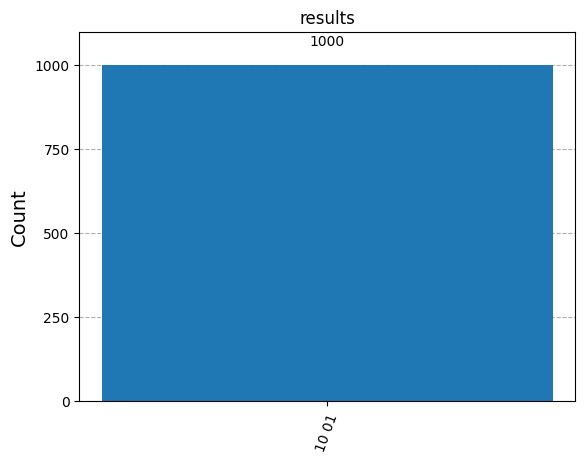

In [4]:
print('We perfromed addition of quantum number '+str(q_num) + ' and classical number ' + str(cl_num) + '.' )
print('The result is the lower half of bits in hystogram x-axis notation')
qr.plot_hyst_func(adder,1000)

# Testing Draper subtraction

1) subtraction does not work if one subtracts a classical number bigger than the quantum one

In [44]:
bit_size = 2

#default numbers
q_num = [0] * bit_size
cl_num = [0] * bit_size

q_num = [1, 0] # quantum number (we assume here pure state, no superposition)
cl_num = [1, 1] #classical number

q_reg    = qiskit.QuantumRegister(bit_size) #this quantum register stores the added quantum number a
cl_reg    = qiskit.ClassicalRegister(bit_size) #this classical register stores classical number b
q_reg_cl    = qiskit.QuantumRegister(bit_size) # this is ancilla qubits to get classical number in the circuit
cl_reg_meas    = qiskit.ClassicalRegister(bit_size) # this classical register stores the result of summation

adder = qiskit.QuantumCircuit(q_reg, cl_reg, q_reg_cl, cl_reg_meas)


adder = qr.qubit_binary_prepare(q_reg, q_num, adder) #prepare quantum number


#prepare classical number
adder = qr.qubit_binary_prepare(q_reg_cl, cl_num, adder) 
adder = qr.qubits_meas(q_reg_cl, cl_reg, adder)

#add_inst = qr.draper_adder_cl_instr(bit_size)
#adder.append(add_inst,q_reg,cl_reg)
add_inst = qr.draper_subtraction_cl_instr(bit_size)
adder.append(add_inst,q_reg,cl_reg)
adder = qr.qubits_meas(q_reg, cl_reg_meas, adder)

adder.draw('mpl')


TypeError: draper_subtraction_cl_instr() missing 1 required positional argument: 'control_bit_size'

We perfromed addition of quantum number [1, 0] and classical number [1, 1].
The result is the lower half of bits in hystogram x-axis notation


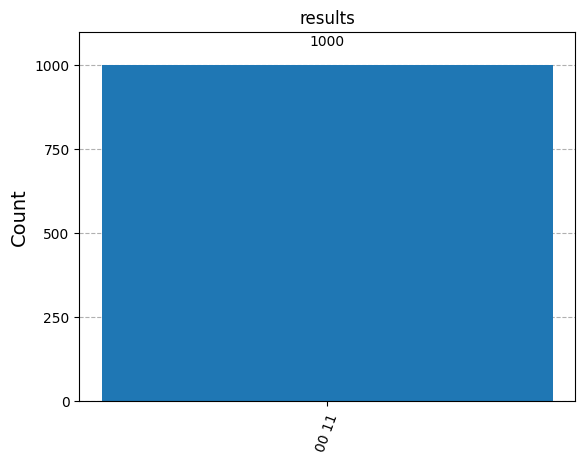

In [45]:
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city
import numpy

simulator = Aer.get_backend('qasm_simulator') 
simulator = AerSimulator()
ShotNum=1000
circ = transpile(adder, simulator)
result = simulator.run(adder.decompose().decompose(),shots=ShotNum).result()
counts = result.get_counts(adder)

print('We perfromed addition of quantum number '+str(q_num) + ' and classical number ' + str(cl_num) + '.' )
print('The result is the lower half of bits in hystogram x-axis notation')
plot_histogram(counts, title='results')


## Below is the Draper adder made in a different way
Instead of having classical register controlling gates as in the examples above, here we just vary the gate set in the adder depending on the input number a.


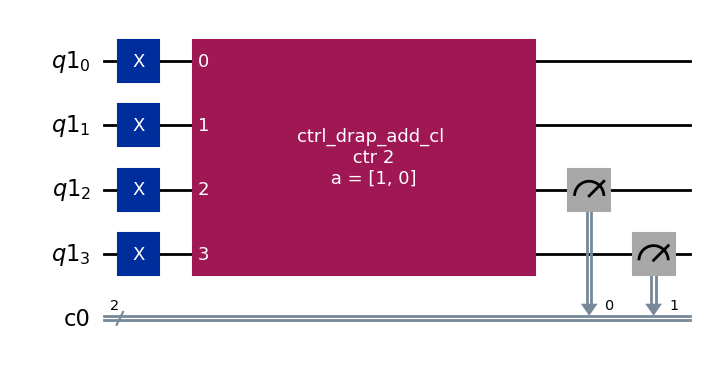

In [1]:
import qiskit
import numpy as np
import quantum_routines as qr
from quantum_routines import QFTn
from quantum_routines import IQFTn

bit_size = 2 #size (number of digits) of the binary number
control_bit_size = 2

#default numbers
q_num = [0] * bit_size
cl_num = [0] * bit_size
contr_num = [0] * control_bit_size

q_num = [1, 1] # quantum number (we assume here pure state, no superposition)
cl_num = [1, 0] #classical number
contr_num = [1, 1] #control number

q_reg    = qiskit.QuantumRegister(bit_size + control_bit_size) #this quantum register stores the added quantum number a
cl_reg_meas    = qiskit.ClassicalRegister(bit_size) # this classical register stores the result of summation

adder = qiskit.QuantumCircuit(q_reg, cl_reg_meas)

qbit_list = list(range(control_bit_size, control_bit_size + bit_size))
adder = qr.qubit_binary_prepare(q_reg[qbit_list], q_num, adder) #prepare quantum number

#prepare control qubits
qbit_list = list(range(control_bit_size))
adder = qr.qubit_binary_prepare(q_reg[qbit_list], contr_num, adder)

adder_gate = qr.draper_adder_cl_gate(bit_size, control_bit_size, cl_num)
adder.append(adder_gate, q_reg)

#adder_instr = qr.draper_subtraction_cl_instr(bit_size, control_bit_size)
#adder.append(adder_instr, q_reg, cl_reg)

qbit_list = list(range(control_bit_size, control_bit_size + bit_size))
adder = qr.qubits_meas(q_reg[qbit_list], cl_reg_meas, adder)

adder.draw('mpl')

We perfromed addition of quantum number [1, 1] and classical number [1, 0].
The result is the lower half of bits in hystogram x-axis notation


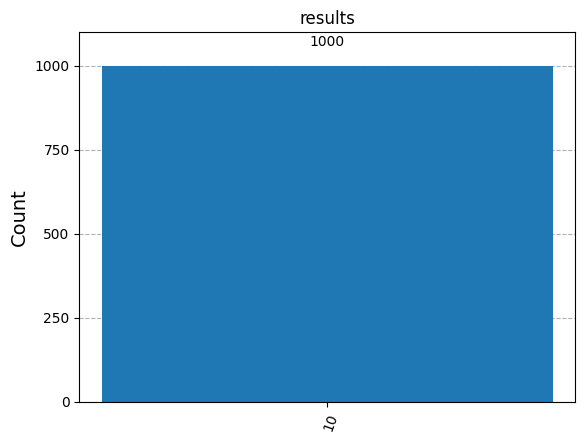

In [2]:
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city
import numpy

simulator = Aer.get_backend('qasm_simulator') 
simulator = AerSimulator()
ShotNum=1000
circ = transpile(adder, simulator)
result = simulator.run(adder.decompose().decompose(),shots=ShotNum).result()
counts = result.get_counts(adder)

print('We perfromed addition of quantum number '+str(q_num) + ' and classical number ' + str(cl_num) + '.' )
print('The result is the lower half of bits in hystogram x-axis notation')
plot_histogram(counts, title='results')
